# MODULE IMPORT

In [1]:
%load_ext watermark

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from netCDF4 import Dataset

In [4]:
from scipy.interpolate import interp1d
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

In [5]:
import glob
import pandas as pd
import json

In [6]:
import matplotlib as mpl
#label_size = 30
#mpl.rcParams['xtick.labelsize'] = label_size
#mpl.rcParams['ytick.labelsize'] = label_size
#mpl.rcParams['axes.labelsize'] = 21
#mpl.rcParams['axes.titlesize'] = 23
#mpl.rcParams['figure.titlesize'] = 36

label_size = 10
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['axes.labelsize'] = 11
mpl.rcParams['axes.titlesize'] = 13
mpl.rcParams['figure.titlesize'] = 20

In [7]:
import pyproj

In [8]:
utm33 = pyproj.Proj("+proj=utm +zone=33, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

In [9]:
%watermark -iv

matplotlib 3.2.1
autopep8   1.5.2
pyproj     2.6.0
json       2.0.9
pandas     1.0.3
numpy      1.18.1



## functions


In [10]:
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.lines as mlines


def plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap='magma_r',
                         fmat="%.1f", shiftx=10000, shifty=7000, colors=None,
                         quiver=False,profile=False):
    
    title=txt.split('[')[0]
    try:
        umis='['+txt.split('[')[1]
    except:
        umis=''
    if v_a is not None and quiver is False:
        cont = ax.contourf(utmx_a, utmy_a, v_a, levels=50,
                           vmin=vmin, vmax=vmax, cmap=cmap)
        cont2 = ax.contourf(utmx_b-shiftx, utmy_b-shifty, v_b, levels=50,
                            alpha=1, vmin=vmin, vmax=vmax, cmap=cmap)
    elif quiver is False:
        cont = ax.contourf(utmx_a, utmy_a, utmx_a*0, levels=50,
                           vmin=vmin, vmax=vmax, cmap=cmap)
        cont2 = ax.contourf(utmx_b-shiftx, utmy_b-shifty, utmx_b*0, levels=50,
                            alpha=1, vmin=vmin, vmax=vmax, cmap=cmap)

    patches = []
    polygon = Polygon(poly_a, True)
    patches.append(polygon)
    #polygon = Polygon(poly_b, True)
    #patches.append(polygon)
    polygon = Polygon(poly_c, True)
    patches.append(polygon)
    p = PatchCollection(patches, facecolor='none',
                        edgecolor='k', linewidth=2, alpha=1)
    ax.add_collection(p)

    patches = []
    polygon = Polygon(poly_b, True)
    patches.append(polygon)
    px = [utmx_b[b2]-shiftx, utmx_b[b2]]
    py = [utmy_b[b2]-shifty, utmy_b[b2]]
    line = mlines.Line2D(px, py)
    patches.append(line)
    px = [utmx_b[b3]-shiftx, utmx_b[b3]]
    py = [utmy_b[b3]-shifty, utmy_b[b3]]
    line = mlines.Line2D(px, py)
    patches.append(line)
    px = [utmx_b[b4]-shiftx, utmx_b[b4]]
    py = [utmy_b[b4]-shifty, utmy_b[b4]]
    line = mlines.Line2D(px, py)
    patches.append(line)
    p = PatchCollection(patches, facecolor='none',
                        edgecolor='k', linewidth=1, alpha=0.6)
    ax.add_collection(p)

    # cont = ax.pcolor(utmx_a, utmy_a, v_a,
    #                   vmin=vmin, vmax=vmax, cmap=cmap)
    # cont2 = ax.pcolor(utmx_b, utmy_b, v_b,
    #                     vmin=vmin, vmax=vmax, cmap=cmap)
    #

    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    if v_a is not None:
        if type(cmap) == matplotlib.colors.ListedColormap:
            if len(colors) == 2:
                length = (vmax-vmin)/2.
                clb = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ticks=[
                    vmin+length/2., vmax-length/2.], spacing='proportional', format=fmat, orientation='horizontal')
                clb.ax.set_xticklabels([vmin, vmax])
            elif len(colors) == 1:
                clb = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ticks=[
                    vmin], spacing='proportional', format=fmat, orientation='horizontal')
                clb.ax.set_xticklabels([round(vmin,1)])
    
        else:
            clb = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ticks=np.linspace(
                vmin, vmax, 3), spacing='proportional', format=fmat, orientation='horizontal')
        clb.set_label(umis)
    else:
        clb = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ticks=[],
                           spacing='proportional', format=fmat, orientation='horizontal')
        clb.outline.set_visible(False)
        
    if quiver:
        decimation=5
        U = np.cos(np.radians(-65+rake_a))
        V = np.sin(np.radians(-65+rake_a))
        ax.quiver(utmx_a[::decimation, ::decimation], 
                  utmy_a[::decimation, ::decimation], 
                  U[::decimation, ::decimation], V[::decimation, ::decimation],
                  color='k',
                  width=.026,alpha=1,cmap=cmap,norm=norm)
        ax.quiver(utmx_a[::decimation, ::decimation], 
                  utmy_a[::decimation, ::decimation], 
                  U[::decimation, ::decimation], V[::decimation, ::decimation],
                  v_a[::decimation, ::decimation],
                  width=.025,alpha=1,cmap=cmap,norm=norm)
        U = np.cos(np.radians(-120+rake_b))
        V = np.sin(np.radians(-120+rake_b))
        ax.quiver(utmx_b[::decimation, ::decimation]-shiftx, 
                  utmy_b[::decimation, ::decimation]-shifty, 
                  U[::decimation, ::decimation], V[::decimation, ::decimation],
                  color='k',
                  width=.026,alpha=1,cmap=cmap,norm=norm)
        ax.quiver(utmx_b[::decimation, ::decimation]-shiftx, 
                  utmy_b[::decimation, ::decimation]-shifty, 
                  U[::decimation, ::decimation], V[::decimation, ::decimation],
                  v_b[::decimation, ::decimation],
                  width=.025,alpha=1,cmap=cmap,norm=norm)
    
    if profile:
        ax.plot(utmx_a[l,:],utmy_a[l,:],'r--',lw=2)
    
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.set_xticks(labelx)
    ax.set_xticklabels([round(xl, 2) for xl in labellon])
    ax.set_xlim(utmx_a.min()-shiftx, utmx_a.max())
    ax.set_yticks(labely)
    ax.set_yticklabels([round(xl, 2) for xl in labellat])
    #ax.set_ylim(utmy_a.min(), utmy_a.max())
    ax.set_axis_off()



In [11]:
def rotate(sxx, syy, sxy, sxz, syz, szz=0, thetax=0, thetay=0, thetaz=0):
    rad_thetax = np.radians(thetax)
    rad_thetay = np.radians(thetay)
    rad_thetaz = np.radians(thetaz)
    cx = np.cos(rad_thetax)
    cy = np.cos(rad_thetay)
    cz = np.cos(rad_thetaz)
    sx = np.sin(rad_thetax)
    sy = np.sin(rad_thetay)
    sz = np.sin(rad_thetaz)

    Tx = np.array([[1, 0, 0],
                      [0, cx, -sx],
                      [0, sx,  cx]])
    Ty = np.array([[cy, 0, -sy],
                      [0, 1, 0],
                      [sy, 0, cy]])
    Tz = np.array([[cz, -sz, 0],
                      [sz, cz, 0],
                      [0, 0, 1]])

    A = np.array([[sxx, sxy, sxz],
                     [sxy, syy, syz],
                     [sxz, syz,  szz]])

    A_tempx = np.matmul(np.matmul(Tx, A), np.transpose(Tx))
    A_tempy = np.matmul(np.matmul(Ty, A_tempx), np.transpose(Ty))
    Stress_in_global_xyz = np.matmul(
        np.matmul(Tz, A_tempy), np.transpose(Tz))

    return A, Stress_in_global_xyz

In [12]:
def rotating_stress_tensor(stress_a, stress_b,rake_a=None,rake_b=None):
    s_yy_a = 0.*tmp_a.ravel()
    s_zz_a = 0.*tmp_a.ravel()
    s_yz_a = 0.*tmp_a.ravel()
    s_xx_a = 0*tmp_a.ravel()
    s_xz_a = 0*tmp_a.ravel()
    s_xy_a = 0*tmp_a.ravel()
    
    if rake_a is not None:
        stress_a_0=stress_a*np.cos(np.radians(rake_a))
        stress_a_90=-stress_a*np.sin(np.radians(rake_a))
    else:
        stress_a_0=stress_a
        stress_a_90=stress_a
    
    for i,(s0,s90,sn) in enumerate(zip(stress_a_0.ravel(),stress_a_90.ravel(),NORMAL_STRESS_a.ravel())):
        _,snew=rotate(sxx=0,syy=-sn*1e6,sxy=-s0*1e6,sxz=0,syz=s90*1e6,szz=0,thetax=dip_a-90,thetay=0,thetaz=90-strike_a)

        s_yy_a[i] = snew[1, 1]
        s_zz_a[i] = snew[2, 2]
        s_yz_a[i] = snew[2, 1]
        s_xx_a[i] = snew[0, 0]
        s_xz_a[i] = snew[2, 0]
        s_xy_a[i] = snew[1, 0]

    s_yy_a.shape = stress_a.shape
    s_zz_a.shape = stress_a.shape
    s_yz_a.shape = stress_a.shape
    s_xx_a.shape = stress_a.shape
    s_xz_a.shape = stress_a.shape
    s_xy_a.shape = stress_a.shape

    s_yy_b = 0.*tmp_b.ravel()
    s_zz_b = 0.*tmp_b.ravel()
    s_yz_b = 0.*tmp_b.ravel()
    s_xx_b = 0*tmp_b.ravel()
    s_xz_b = 0*tmp_b.ravel()
    s_xy_b = 0*tmp_b.ravel()
    
    if rake_b is not None:
        stress_b_0=stress_b*np.cos(np.radians(rake_b))
        stress_b_90=-stress_b*np.sin(np.radians(rake_b))
    else:
        stress_b_0=stress_b
        stress_b_90=stress_b
        
    for i,(s0b,s90b,sn) in enumerate(zip(stress_b_0.ravel(),stress_b_90.ravel(),NORMAL_STRESS_b.ravel())):
        _,snew=rotate(sxx=0,syy=-sn*1e6,sxy=-s0b*1e6,sxz=0,syz=s90b*1e6,szz=0,thetax=dip_b-90,thetay=0,thetaz=90-strike_b) #beware of the negative sign of sn
        

    # beware of the negative sign of sn
        s_yy_b[i] = snew[1, 1]
        s_zz_b[i] = snew[2, 2]
        s_yz_b[i] = snew[2, 1]
        s_xx_b[i] = snew[0, 0]
        s_xz_b[i] = snew[2, 0]
        s_xy_b[i] = snew[1, 0]

    s_yy_b.shape = stress_b.shape
    s_zz_b.shape = stress_b.shape
    s_yz_b.shape = stress_b.shape
    s_xx_b.shape = stress_b.shape
    s_xz_b.shape = stress_b.shape
    s_xy_b.shape = stress_b.shape
    
    

    return s_yy_a, s_zz_a, s_yz_a, s_xx_a, s_xz_a, s_xy_a, s_yy_b, s_zz_b, s_yz_b, s_xx_b, s_xz_b, s_xy_b

# GEOMETRY

In the reference system with x along strike direction of 155 fault, y perpendicular to x and z up positive, the fault 155 is oriented with strike 0 and dip 47.

In [13]:
fault155_dip=90-47 #starting from z-
fault155_strike=0 # fault155 is oriented along x

rx1 = R.from_euler('x', -fault155_dip, degrees=True) #around X for dip 
rx2 = R.from_euler('z', fault155_strike, degrees=True) #around Z for strike
rx = rx2*rx1

fault210_dip=90-36 #starting from z-
fault210_strike=-55 # fault210 strike is 155-210 where 155 is oriented along x

nx1 = R.from_euler('x', -fault210_dip, degrees=True) #around X for dip 
nx2 = R.from_euler('z', fault210_strike, degrees=True) #around Z for strike
nx = nx2*nx1

nx3 =R.from_euler('y',-5.86085404017178, degrees=True)
px=nx3*nx2*nx1
px2=nx*nx3

In [14]:
n155=rx.apply([0,-1,0]) #rotation
print('normal 155',n155)

normal 155 [ 0.         -0.7313537   0.68199836]


In [15]:
n210=nx.apply([0,-1,0]) #rotation 
print('normal 210',n210)

normal 210 [-0.48148549 -0.33713977  0.80901699]


In [16]:
retta=np.cross(n210,n155)
retta=retta/np.linalg.norm(retta)
print ('fault 210 dip direction',retta)

#find perpendicular to retta and normal to 210
perp=np.cross(retta,n210)
perp=perp/np.linalg.norm(perp)
print('fault 210 strike direction',perp)

fault 210 dip direction [0.60067427 0.5452535  0.58471279]
fault 210 strike direction [ 0.63824928 -0.76748642  0.06002046]


In [17]:
origin = [348441.37745855964, 4760209.936366674, 0]
hypocenter = [345545.0171306281 - origin[0],
              4744751.470962405 - origin[1],
              -9520.0]

rotz = R.from_euler('z', -90+155, degrees=True)
_hypo_meshcoord = rotz.apply(hypocenter)

epicenter = _hypo_meshcoord-[17000, 0, 0] #traslation
zhypo = -(n155[0]*epicenter[0]+n155[1]*epicenter[1])/n155[2] #depth along dip
hypo_meshcoord=np.array([epicenter[0], epicenter[1], zhypo])

firstcorner = hypo_meshcoord-500*retta
secondcorner = firstcorner+14000*retta
thirdcorner = firstcorner+10000*perp
forthcorner = secondcorner+10000*perp

# NUCLEATION

In [18]:
#from SCEC
def nu(r,Vs=4000,r_crit=3000): 
    return r/(0.7*Vs)+(0.081*r_crit/(0.7*Vs))*(1.0/(1.0-pow(r/r_crit, 2.0))-1.0)

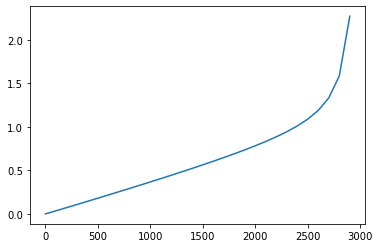

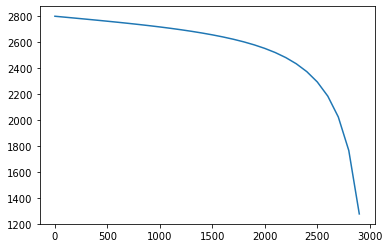

In [19]:
rra=np.arange(0.01,3000,100)
y=nu(rra);
plt.figure()
plt.plot(rra,y)
plt.figure()
plt.plot(rra,rra/y)

# GEOMETRY of the FAULTS

In [20]:
hypocenter_geo = [13.11, 42.8398, -9.52*1000]

Inserire qui una figura sulla geometria delle faglie

The orientation of the reference system has been defined for simplifying the orientation of the 2 faults: the x axis is parallel to the strike vector of the fault F155, the y axis is perpendicular with the positive direction  in the F155 footwall space. 

## GEOMETRY FAULT F155

In [21]:
dip_a = 47.
strike_a = 90.  # because the main fault is along x axis

In [22]:
step = 200.  # meters
nz0_a = 33
nx0_a = 69
tmp_a = np.ones([nx0_a, nz0_a])

## GEOMETRY FAULT F210

In [23]:
dip_b = 36.
strike_b = 145.  # because the main fault is along x axis, 210-155+90

directiondip = retta.copy()
directiondip.shape = (3, 1)
directionstrike = perp.copy()
directionstrike.shape = (3, 1)

In [24]:
step = 200.  # meters
nz0_b = 29
nx0_b = 21
tmp_b = np.ones([nx0_b, nz0_b])

# Load kinematic model proposed by Scognamiglio et al. 2018

In [25]:
# % lon lat depth(km) x(km) y(km) dx dy slip(m) rake dip strike timerup(s) rise(s)
slipfile_a = 'modelloAAgeorefzeroshallowslip.out'
slipfile_b = 'modelloBBgeoref.out'

In [26]:
d_a = np.loadtxt(slipfile_a, skiprows=1, delimiter=' ',
                 usecols=[0, 1, 2, 3, 4, 7, 8])
d_b = np.loadtxt(slipfile_b, skiprows=1, delimiter=' ',
                 usecols=[0, 1, 2, 3, 4, 7, 8])

In [27]:
lons_a = d_a[:, 0]
lats_a = d_a[:, 1]
depths_a = d_a[:, 2]*1000
xs_a = d_a[:, 3]
ys_a = d_a[:, 4]
slip_a = d_a[:, 5]
rake_a = d_a[:, 6]

In [28]:
lons_b = d_b[:, 0]
lats_b = d_b[:, 1]
depths_b = d_b[:, 2]*1000
xs_b = d_b[:, 3]
ys_b = d_b[:, 4]
slip_b = d_b[:, 5]
rake_b = d_b[:, 6]

In [29]:
slip_b.shape = (nx0_b, nz0_b)
lons_b.shape = (nx0_b, nz0_b)
lats_b.shape = (nx0_b, nz0_b)
xs_b.shape = (nx0_b, nz0_b)
ys_b.shape = (nx0_b, nz0_b)
depths_b.shape = (nx0_b, nz0_b)  # vertical along z coordinates
rake_b.shape = (nx0_b, nz0_b)

In [30]:
slip_a.shape = (nx0_a, nz0_a)
lons_a.shape = (nx0_a, nz0_a)
lats_a.shape = (nx0_a, nz0_a)
xs_a.shape = (nx0_a, nz0_a)
ys_a.shape = (nx0_a, nz0_a)
depths_a.shape = (nx0_a, nz0_a)  # vertical along z coordinates
rake_a.shape = (nx0_a, nz0_a)

In [31]:
gsmal_a=slip_a<0.05
rake_a_mod=rake_a.copy()
rake_a_mod[gsmal_a]=-90

gsmal_b=slip_b<0.05
rake_b_mod=rake_b.copy()
rake_b_mod[gsmal_b]=-10

In [32]:
dist = np.sqrt(
    (lons_a-hypocenter_geo[0])**2+(lats_a-hypocenter_geo[1])**2+(depths_a-hypocenter_geo[2])**2)
ind_ipo = np.unravel_index(np.argmin(dist, axis=None), dist.shape)
ind_ipo_b=(0,27)

In [33]:
# translate since the origin in the slip model is in the center of the subfault (2kmx2km)
xs_a = xs_a * 1000 + 1000
xs_b = xs_b * 1000 + 1000

ys_a = ys_a * 1000 - 1000
ys_b = ys_b * 1000 -1000

In [34]:
x_a = np.linspace(np.min(xs_a), np.max(xs_a), nx0_a)
z_a = np.linspace(np.max(ys_a), np.min(ys_a), nz0_a)
x_b = np.linspace(np.min(xs_b), np.max(xs_b), nx0_b)
z_b = np.linspace(np.max(ys_b), np.min(ys_b), nz0_b)

In [35]:
nx_a = len(x_a)
nz_a = len(z_a)
zv_a, xv_a = np.meshgrid(z_a, x_a)

nx_b = len(x_b)
nz_b = len(z_b)
zv_b, xv_b = np.meshgrid(z_b, x_b)

In [36]:
matrix_zv_b=zv_b.ravel()
matrix_zv_b.shape=(zv_b.ravel().shape[0],1)
matrix_xv_b=xv_b.ravel()
matrix_xv_b.shape=(xv_b.ravel().shape[0],1)

z along fault ---> real depth

In [37]:
new_zv_b = secondcorner + \
            matrix_xv_b * directionstrike.T + \
            matrix_zv_b*directiondip.T

depth_z_b = new_zv_b[:, 2]
depth_z_b.shape = zv_b.shape

depth_z_a = zv_a*np.sin(np.radians(dip_a))

conversion in utm 33 coordinates

In [38]:
utmx_a,utmy_a=utm33(lons_a,lats_a)
print('SHIFT FAULT.YAML',ind_ipo)
print(utmx_a[0][0],utmy_a[0][0])
print(utmx_a[ind_ipo[0]][ind_ipo[1]],utmy_a[ind_ipo[0]][ind_ipo[1]],depths_a[ind_ipo[0]][ind_ipo[1]])

utmx_b,utmy_b=utm33(lons_b,lats_b)
print('SHIFT FAULT.YAML')
print(utmx_b[0][0],utmy_b[0][0])

SHIFT FAULT.YAML (26, 26)
348441.37745855964 4760209.936366674
345545.0171306281 4744751.470962405 -9520.0
SHIFT FAULT.YAML
355273.6147200515 4739487.030371043


In [39]:
labellat=np.arange(42.7,43,0.1)
labely=[utm33(13.019618,l)[1] for l in labellat]

labellon=np.arange(13.0,13.4,0.1)
labelx=[utm33(l,42.6607246)[0] for l in labellon]

In [40]:
#fault polygon for figures
a1=utmx_a==utmx_a.min()
a2=utmy_a==utmy_a.min()
a4=utmy_a==utmy_a.max()
a3=utmx_a==utmx_a.max()

b1=utmx_b==utmx_b.min()
b2=utmy_b==utmy_b.min()
b4=utmy_b==utmy_b.max()
b3=utmx_b==utmx_b.max()

poly_b=np.array([utmx_b[b1],utmy_b[b1],
                 utmx_b[b2],utmy_b[b2],
                 utmx_b[b3],utmy_b[b3],
                 utmx_b[b4],utmy_b[b4]] )
poly_b.shape=(4,2)

poly_a=np.array([utmx_a[a1],utmy_a[a1],
                 utmx_a[a2],utmy_a[a2],
                 utmx_a[a3],utmy_a[a3],
                 utmx_a[a4],utmy_a[a4]] )
poly_a.shape=(4,2)

poly_c=np.array([utmx_b[b1]-10000,utmy_b[b1]-7000,
                 utmx_b[b2]-10000,utmy_b[b2]-7000,
                 utmx_b[b3]-10000,utmy_b[b3]-7000,
                 utmx_b[b4]-10000,utmy_b[b4]-7000] )
poly_c.shape=(4,2)

# INITIAL DYNAMIC PARAMETERS

In [41]:
gravity = 9.8  # [m/s^2]
rho_val = 2700  # [kg/m^3]

Density profile of the 1D nnCIA profile (Herrmann et al. 2011)

In [42]:
z_nncia = [-1500., -4500, -7500, -14500, 
           -29500, -35500, -43500, -100000]  # [meters]
rho_nncia = [2275.3, 2485.8, 2705.8, 2609.3,
             2677., 3000.2, 3012., 3206.]  # [kg/m^3]

## HOMOGENEUS FAMILY

In [43]:
NOME_SIMULAZIONE='H_family'

### dynamic friction $\mu_d$ , static friction $\mu_s$

In [44]:
MU_D = 0.2  # dynamic friction
MU_S = 0.6  # static friction
MU_TR = 10.  # maximum static friction

### Dc, slip weaking critical distance

In [45]:
D_CR_b=0.6*tmp_b # Dc is a constant % of total slip
D_CR_a=1.2*tmp_a # Dc is a constant % of total slip

### Density 

In [46]:
DENSITY_METHOD = 'vertical_depth_dependent'
rho_b = rho_val*tmp_b
rho_a = rho_val*tmp_a

for zrho, rho_val in zip(z_nncia[::-1], rho_nncia[::-1]):
    # print(zrho,rho_val,zrho/np.sin(dip*np.pi/180))
    criterium = depth_z_a >= zrho
    rho_a[criterium] = rho_val
    criterium = depth_z_b >= zrho
    rho_b[criterium] = rho_val


rho_a = rho_a-1000  # adding the presence of fluid
rho_b = rho_b-1000  # adding the presence of fluid

### Normal stress $\sigma_n$

In [47]:
NORMAL_STRESS_METHOD='vertical_depth_dependent'

# zv is negative but NORMAL_STRESS is positive in compression
NORMAL_STRESS_a = -rho_a*gravity*depth_z_a/1e6 # [MPa]
NORMAL_STRESS_uni_a = -rho_val*gravity*depth_z_a/1e6 # [MPa]

# zv is negative but NORMAL_STRESS is positive in compression
NORMAL_STRESS_b = -rho_b*gravity*depth_z_b/1e6 # [MPa]
NORMAL_STRESS_uni_b = -rho_val*gravity*depth_z_b/1e6 # [MPa]


sn_thre = 1  # [MPa]
NORMAL_STRESS_a[NORMAL_STRESS_a < sn_thre] = sn_thre
NORMAL_STRESS_b[NORMAL_STRESS_b < sn_thre] = sn_thre

### initial stress $\tau_{o}$, dynamic frictional stress $\tau_{f}=\mu_d\sigma_n$, yield stress $\tau_{y}$

In [48]:
TAU_Y_a = NORMAL_STRESS_a*MU_S
TAU_Y_b = NORMAL_STRESS_b*MU_S

TAU_F_a = NORMAL_STRESS_a*MU_D
TAU_F_b = NORMAL_STRESS_b*MU_D

$\tau_{o}$ is set 63% of $\tau_{y}=\mu_s\sigma_n$ before increasing $\tau_{y}$ close to the surface

In [49]:
TAU_0_a = TAU_Y_a*0.63
TAU_0_b = TAU_Y_b*0.63

In [50]:
mu_s_a = TAU_Y_a/NORMAL_STRESS_a
mu_s_a = np.minimum(mu_s_a, MU_TR)
TAU_Y_a = mu_s_a*NORMAL_STRESS_a

mu_s_b = TAU_Y_b/NORMAL_STRESS_b
mu_s_b = np.minimum(mu_s_b, MU_TR)
TAU_Y_b = mu_s_b*NORMAL_STRESS_b

In [51]:
mu_d_a = TAU_F_a/NORMAL_STRESS_a
mu_d_b = TAU_F_b/NORMAL_STRESS_b

In [52]:
stress_a=TAU_0_a
stress_b=TAU_0_b

In [53]:
R_a=np.round((stress_a-TAU_F_a)/(TAU_Y_a-TAU_F_a),1)
R_b=np.round((stress_b-TAU_F_b)/(TAU_Y_b-TAU_F_b),1)

### rotating stress tensor

In [54]:
s_yy_a, s_zz_a, s_yz_a, s_xx_a, s_xz_a, s_xy_a, s_yy_b, s_zz_b, s_yz_b, s_xx_b, s_xz_b, s_xy_b = rotating_stress_tensor(stress_a, stress_b)

### plot H

0.4 0.4
-161.7298522340632 161.7298522340632


Text(0.5, 0.98, 'H FAMILY')

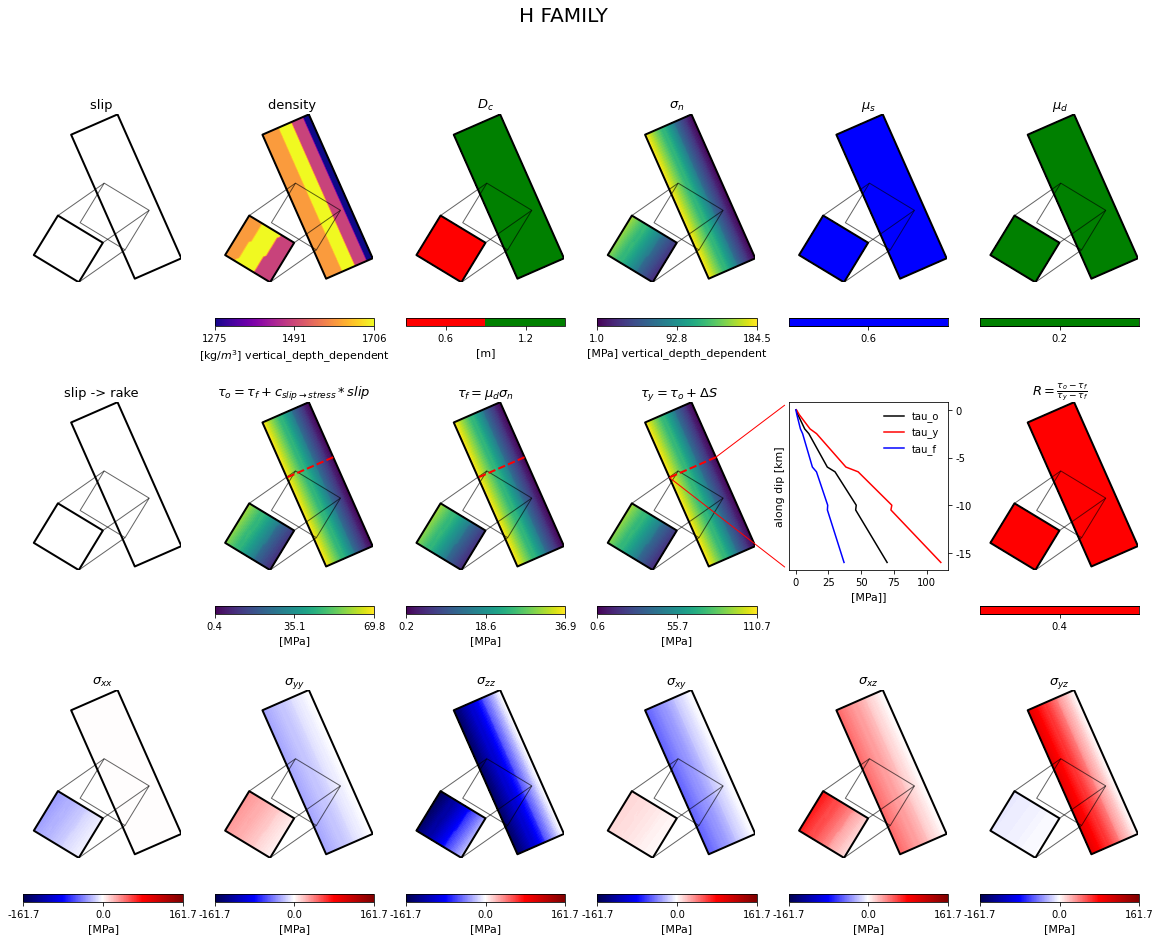

In [55]:
### H FAMILY
fig = plt.figure(figsize=(20, 15))
plt.tight_layout()

icol = 6
irow = 3
l=ind_ipo[0]

i = 1
ax = fig.add_subplot(irow, icol, i)
v_a = None  # slip_a
v_b = None  # slip_b
vmin = 0  # min(v_a.min(),v_b.min())
vmax = 0  # max(v_a.max(),v_b.max())
txt = 'slip [m]'
colors = ['white']
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap=plt.cm.colors.ListedColormap(colors), colors=colors)

i = 2
ax = fig.add_subplot(irow, icol, i)
v_a = rho_a
v_b = rho_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = 'density [kg/$m^3$] '+DENSITY_METHOD
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax,
                         txt, cmap='plasma', fmat="%.0f")

i = 3
ax = fig.add_subplot(irow, icol, i)
v_a = D_CR_a
v_b = D_CR_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$D_c$ [m]'
colors = ['red', 'green']
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap=plt.cm.colors.ListedColormap(colors), colors=colors)

i = 4
ax = fig.add_subplot(irow, icol, i)
v_a = NORMAL_STRESS_a
v_b = NORMAL_STRESS_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\sigma_n$ [MPa] '+NORMAL_STRESS_METHOD
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap='viridis')


i = 5
ax = fig.add_subplot(irow, icol, i)
v_a = mu_s_a
v_b = mu_s_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\mu_s$'
colors = ['blue']
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap=plt.cm.colors.ListedColormap(colors), colors=colors)

i = 6
ax = fig.add_subplot(irow, icol, i)
v_a = mu_d_a
v_b = mu_d_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\mu_d$'
colors = ['green']
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap=plt.cm.colors.ListedColormap(colors), colors=colors)
###########

i = 7
ax = fig.add_subplot(irow, icol, i)
v_a = None
v_b = None
vmin = 0# min(v_a.min(), v_b.min())
vmax = 0# max(v_a.max(), v_b.max())
txt = 'slip -> rake [m]'
colors = ['white']
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap=plt.cm.colors.ListedColormap(colors), colors=colors)


i = 8
ax = fig.add_subplot(irow, icol, i)
v_a = TAU_0_a
v_b = TAU_0_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\\tau_{o} = \\tau_{f} + c_{slip \\rightarrow stress}*slip$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap='viridis',profile=True)


i = 9
ax = fig.add_subplot(irow, icol, i)
v_a = TAU_F_a
v_b = TAU_F_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\\tau_f = \\mu_{d} \\sigma_{n}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap='viridis',profile=True)


i = 12
ax = fig.add_subplot(irow, icol, i)
v_a = R_a
v_b = R_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
print(vmin, vmax)
txt = '$R = \\frac{\\tau_o - \\tau_f }{\\tau_y - \\tau_f}$'
colors = ['red']
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap=plt.cm.colors.ListedColormap(colors), colors=colors)


v=np.concatenate([s_yy_a.ravel(), s_zz_a.ravel(), s_yz_a.ravel(), s_xx_a.ravel(), 
                s_xz_a.ravel(), s_xy_a.ravel(), s_yy_b.ravel(), s_zz_b.ravel(),
                s_yz_b.ravel(), s_xx_b.ravel(), s_xz_b.ravel(), s_xy_b.ravel()])

vmin=-max(abs(v.min()/1e6),abs(v.max()/1e6))
vmax=max(abs(v.min()/1e6),abs(v.max()/1e6))
print(vmin,vmax)
cmap='seismic'

i = 13
ax = fig.add_subplot(irow, icol, i)
v_a = s_xx_a/1e6
v_b = s_xx_b/1e6
txt = '$\sigma_{xx}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmap)


i = 14
ax = fig.add_subplot(irow, icol, i)
v_a = s_yy_a/1e6
v_b = s_yy_b/1e6
txt = '$\sigma_{yy}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmap)

i = 15
ax = fig.add_subplot(irow, icol, i)
v_a = s_zz_a/1e6
v_b = s_zz_b/1e6
txt = '$\sigma_{zz}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmap)

i = 16
ax = fig.add_subplot(irow, icol, i)
v_a = s_xy_a/1e6
v_b = s_xy_b/1e6
txt = '$\sigma_{xy}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmap)


i = 17
ax = fig.add_subplot(irow, icol, i)
v_a = s_xz_a/1e6
v_b = s_xz_b/1e6
txt = '$\sigma_{xz}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmap)

i = 18
ax = fig.add_subplot(irow, icol, i)
v_a = s_yz_a/1e6
v_b = s_yz_b/1e6
txt = '$\sigma_{yz}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmap)




i = 10
ax = fig.add_subplot(irow, icol, i)
v_a = TAU_Y_a
v_b = TAU_Y_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = ' $\\tau_y = \\tau_o + \\Delta S$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap='viridis',profile=True)


i = 11
ax1 = fig.add_subplot(irow, icol, i)
ax1.plot(TAU_0_a[l,:],zv_a[l,:],label='tau_o',color='k')
ax1.plot(TAU_Y_a[l,:],zv_a[l,:],label='tau_y',color='r')
ax1.plot(TAU_F_a[l,:],zv_a[l,:],label='tau_f',color='b')
ax1.legend(frameon=False)
ax1.yaxis.tick_right()
ax1.set_yticks([0,-5000,-10000,-15000])
ax1.set_yticklabels(str(_) for _ in [0,-5,-10,-15])
ax1.set_ylabel('along dip [km]')
ax1.set_xlabel('[MPa]]')
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
clb = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=plt.cm.colors.ListedColormap(['white'])), ticks=[],
                           spacing='proportional', format='%.1f', orientation='horizontal')
clb.outline.set_visible(False)
from matplotlib.patches import ConnectionPatch
xy=(utmx_a[l,0],utmy_a[l,0])
xy1=(0,1)
con = ConnectionPatch(
    xyA=xy, coordsA=ax.transData,
    xyB=xy1, coordsB=ax1.transAxes,
    arrowstyle="-", shrinkB=5,color='r')
ax1.add_artist(con)
xy=(utmx_a[l,-1],utmy_a[l,-1])
xy1=(0,0)
con = ConnectionPatch(
    xyA=xy, coordsA=ax.transData,
    xyB=xy1, coordsB=ax1.transAxes,
    arrowstyle="-", shrinkB=5,color='r')
ax1.add_artist(con)

plt.suptitle('H FAMILY')

## FAMILY B

In [56]:
NOME_SIMULAZIONE='B_family'

### dynamic friction $\mu_d$ , static friction $\mu_s$

In [57]:
MU_D = 0.2  # dynamic friction
MU_S = 0.5  # static friction
MU_TR = 10.  # maximum static friction

### $D_c$, slip weaking critical distance

$D_c$ is a percentage of the total slip, the percentage depends on the depth

In [58]:
z_nncia=[-1500.,-4500,-7500,-14500,-29500,-35500,-43500,-100000]
dc_nncia=[0.3,0.3,0.1,0.1] 
D_CR_tres=0.02
D_CR_b=0.6*tmp_b 
D_CR_a=0.6*tmp_a 


for zdc,dc_val in zip(z_nncia[len(dc_nncia)-1::-1],dc_nncia[::-1]):
    #print(zdc,dc_val)
    cdc = depth_z_a >= zdc
    D_CR_a[cdc] = dc_val
    cdc = depth_z_b >= zdc
    D_CR_b[cdc] = dc_val
    
D_CR_a=D_CR_a*slip_a
cdc = D_CR_a <= D_CR_tres
D_CR_a[cdc]=D_CR_tres 
print(D_CR_a.min(),D_CR_a.max())

D_CR_b=D_CR_b*slip_b
cdc = D_CR_b <= D_CR_tres
D_CR_b[cdc]=D_CR_tres
print(D_CR_b.min(),D_CR_b.max())

0.02 0.84261537
0.02 0.93737859


### Density 

In [59]:
DENSITY_METHOD = 'vertical_depth_dependent'
rho_b = rho_val*tmp_b
rho_a = rho_val*tmp_a

for zrho, rho_val in zip(z_nncia[::-1], rho_nncia[::-1]):
    # print(zrho,rho_val,zrho/np.sin(dip*np.pi/180))
    criterium = depth_z_a >= zrho
    rho_a[criterium] = rho_val
    criterium = depth_z_b >= zrho
    rho_b[criterium] = rho_val


rho_a = rho_a-1000  # adding the presence of fluid
rho_b = rho_b-1000  # adding the presence of fluid

### Normal stress $\sigma_n$

In [60]:
NORMAL_STRESS_METHOD='vertical_depth_dependent'

# zv is negative but NORMAL_STRESS is positive in compression
NORMAL_STRESS_a = -rho_a*gravity*depth_z_a/1e6 # [MPa]
NORMAL_STRESS_uni_a = -rho_val*gravity*depth_z_a/1e6 # [MPa]

# zv is negative but NORMAL_STRESS is positive in compression
NORMAL_STRESS_b = -rho_b*gravity*depth_z_b/1e6 # [MPa]
NORMAL_STRESS_uni_b = -rho_val*gravity*depth_z_b/1e6 # [MPa]


sn_thre = 1  # [MPa]
NORMAL_STRESS_a[NORMAL_STRESS_a < sn_thre] = sn_thre
NORMAL_STRESS_b[NORMAL_STRESS_b < sn_thre] = sn_thre

### initial stress $\tau_{o}$, dynamic frictional stress $\tau_{f}=\mu_d\sigma_n$, yield stress $\tau_{y}$

In [61]:
SLIP_2_STRESS_FACTOR_a=4
SLIP_2_STRESS_FACTOR_b=5

In [62]:
TAU_F_a = NORMAL_STRESS_a*MU_D
TAU_F_b = NORMAL_STRESS_b*MU_D

$\tau_{o}$ is set $\tau_{o} = \tau_{f} + c_{slip \rightarrow stress}*slip$

In [63]:
TAU_0_a=TAU_F_a+slip_a*SLIP_2_STRESS_FACTOR_a
TAU_0_b=TAU_F_b+slip_b*SLIP_2_STRESS_FACTOR_b

Strengh excess $\Delta S$ is defined as a function of the distance from the hypocenter $\Delta S = \frac{\tau_{y}^{max}-\tau_{y}^{min}}{r_c}*r+\tau_y^{min}$ with $\tau_y^{min}=0.1$ e $\tau_y^{max}=0.6$

In [64]:
def get_tauy(xx, yy, xxc, yyc, rr_crit=80000, tauy_min=0.1, tauy_max=6):
    ffy=np.ones(xx.shape)*tauy_max
    r=np.sqrt((xx-xxc)**2+(yy-yyc)**2)
    c=r <= rr_crit
    ffy[c]=(tauy_max-tauy_min)/rr_crit*r[c]+tauy_min
    return ffy

STREXCE_a=get_tauy(xv_a,zv_a,xv_a[ind_ipo],zv_a[ind_ipo])
STREXCE_b=get_tauy(xv_b,zv_b,xv_b[ind_ipo_b],zv_b[ind_ipo_b])

$\tau_{y}$ is set $\tau_{y} = \tau_{o} + \Delta S$

In [65]:
TAU_Y_a=TAU_0_a+STREXCE_a
TAU_Y_b=TAU_0_b+STREXCE_b

mu_s_a = TAU_Y_a/NORMAL_STRESS_a
mu_s_a = np.minimum(mu_s_a, MU_TR)
TAU_Y_a = mu_s_a*NORMAL_STRESS_a

mu_s_b = TAU_Y_b/NORMAL_STRESS_b
mu_s_b = np.minimum(mu_s_b, MU_TR)
TAU_Y_b = mu_s_b*NORMAL_STRESS_b

In [66]:
mu_d_a = TAU_F_a/NORMAL_STRESS_a
mu_d_b = TAU_F_b/NORMAL_STRESS_b

In [67]:
stress_a=TAU_0_a
stress_b=TAU_0_b

In [68]:
R_a=np.round((stress_a-TAU_F_a)/(TAU_Y_a-TAU_F_a),1)
R_b=np.round((stress_b-TAU_F_b)/(TAU_Y_b-TAU_F_b),1)

### rotating stress tensor

In [69]:
s_yy_a, s_zz_a, s_yz_a, s_xx_a, s_xz_a, s_xy_a, s_yy_b, s_zz_b, s_yz_b, s_xx_b, s_xz_b, s_xy_b = rotating_stress_tensor(stress_a, stress_b,rake_a_mod,rake_b_mod)

### plot B

0.0 10
FE mean 0.1738948903784462 0.45613879657947215
-131.94183273246648 131.94183273246648


Text(0.5, 0.98, 'B FAMILY')

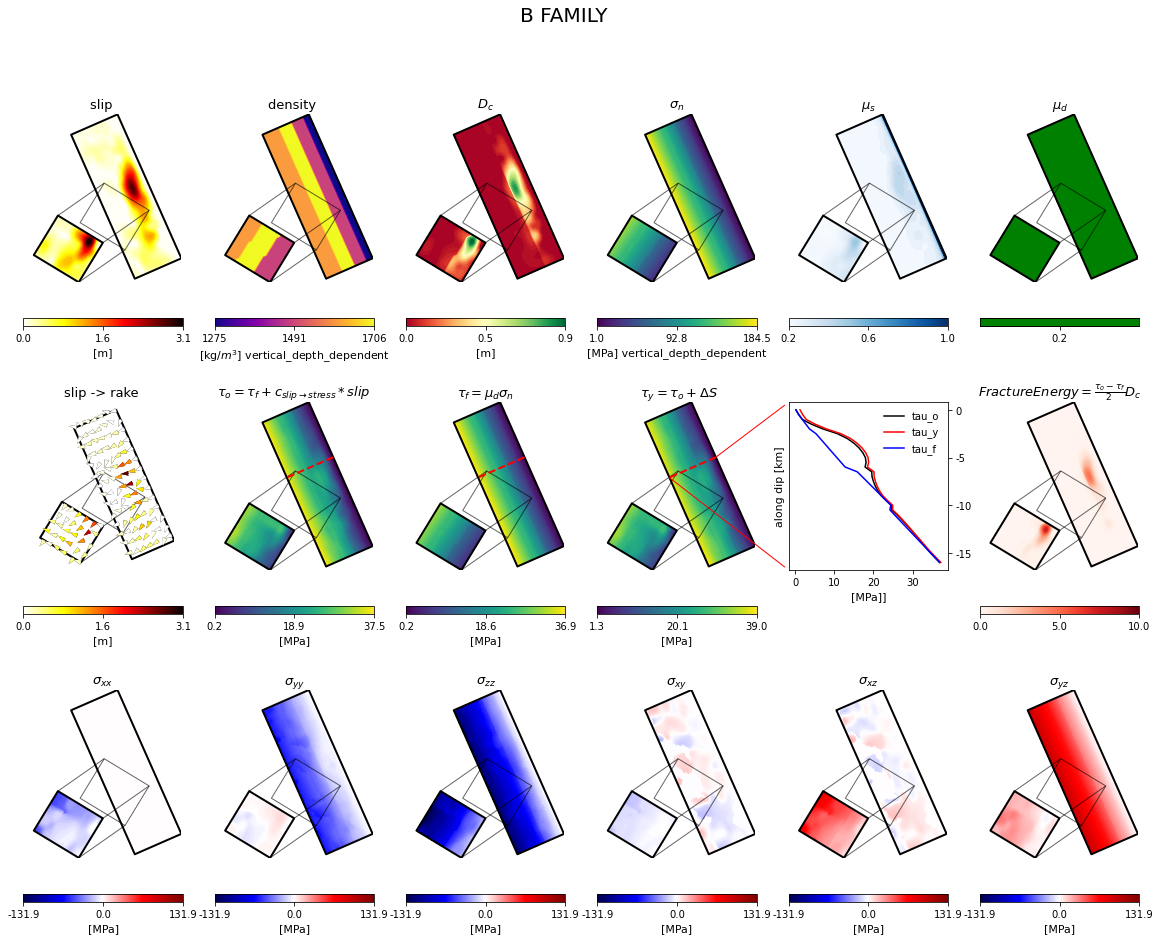

In [70]:
### B FAMILY
fig = plt.figure(figsize=(20, 15))
plt.tight_layout()

icol = 6
irow = 3
l=ind_ipo[0]

i = 1
ax = fig.add_subplot(irow, icol, i)
v_a = slip_a
v_b = slip_b
vmin = min(v_a.min(),v_b.min())
vmax = max(v_a.max(),v_b.max())
txt = 'slip [m]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap='hot_r')

i = 2
ax = fig.add_subplot(irow, icol, i)
v_a = rho_a
v_b = rho_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = 'density [kg/$m^3$] '+DENSITY_METHOD
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax,
                         txt, cmap='plasma', fmat="%.0f")

i = 3
ax = fig.add_subplot(irow, icol, i)
v_a = D_CR_a
v_b = D_CR_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$D_c$ [m]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap='RdYlGn')

i = 4
ax = fig.add_subplot(irow, icol, i)
v_a = NORMAL_STRESS_a
v_b = NORMAL_STRESS_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\sigma_n$ [MPa] '+NORMAL_STRESS_METHOD
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap='viridis')


i = 5
ax = fig.add_subplot(irow, icol, i)
v_a = mu_s_a
v_b = mu_s_b
vmin = min(v_a.min(), v_b.min())
vmax = 1# max(v_a.max(), v_b.max())
txt = '$\mu_s$'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                        cmap='Blues')

i = 6
ax = fig.add_subplot(irow, icol, i)
v_a = mu_d_a
v_b = mu_d_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\mu_d$'
colors = ['green']
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap=plt.cm.colors.ListedColormap(colors), colors=colors)
###########

i = 7
ax = fig.add_subplot(irow, icol, i)
v_a = slip_a
v_b = slip_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = 'slip -> rake [m]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap='hot_r',quiver=True)


i = 8
ax = fig.add_subplot(irow, icol, i)
v_a = TAU_0_a
v_b = TAU_0_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\\tau_{o} = \\tau_{f} + c_{slip \\rightarrow stress}*slip$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap='viridis',profile=True)


i = 9
ax = fig.add_subplot(irow, icol, i)
v_a = TAU_F_a
v_b = TAU_F_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\\tau_f = \\mu_{d} \\sigma_{n}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap='viridis',profile=True)


#i = 12
#ax = fig.add_subplot(irow, icol, i)
#v_a = R_a
#v_b = R_b
#vmin = min(v_a.min(), v_b.min())
#vmax = max(v_a.max(), v_b.max())
#print(vmin, vmax)
#txt = '$R = \\frac{\\tau_o - \\tau_f }{\\tau_y - \\tau_f}$'
#d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
#                         cmap='Reds')

i = 12
ax = fig.add_subplot(irow, icol, i)
v_a = .5*D_CR_a*(TAU_0_a-TAU_F_a)
v_b = .5*D_CR_b*(TAU_0_b-TAU_F_b)
vmin = min(v_a.min(), v_b.min())
vmax = 10#max(v_a.max(), v_b.max())
print(vmin, vmax)
print('FE mean',v_a.mean(), v_b.mean())
txt = '$Fracture Energy = \\frac{\\tau_{o} - \\tau_{f} }{2}D_{c}$'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap='Reds')





v=np.concatenate([s_yy_a.ravel(), s_zz_a.ravel(), s_yz_a.ravel(), s_xx_a.ravel(), 
                s_xz_a.ravel(), s_xy_a.ravel(), s_yy_b.ravel(), s_zz_b.ravel(),
                s_yz_b.ravel(), s_xx_b.ravel(), s_xz_b.ravel(), s_xy_b.ravel()])

vmin=-max(abs(v.min()/1e6),abs(v.max()/1e6))
vmax=max(abs(v.min()/1e6),abs(v.max()/1e6))
print(vmin,vmax)
cmap='seismic'

i = 13
ax = fig.add_subplot(irow, icol, i)
v_a = s_xx_a/1e6
v_b = s_xx_b/1e6
txt = '$\sigma_{xx}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmap)


i = 14
ax = fig.add_subplot(irow, icol, i)
v_a = s_yy_a/1e6
v_b = s_yy_b/1e6
txt = '$\sigma_{yy}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmap)

i = 15
ax = fig.add_subplot(irow, icol, i)
v_a = s_zz_a/1e6
v_b = s_zz_b/1e6
txt = '$\sigma_{zz}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmap)

i = 16
ax = fig.add_subplot(irow, icol, i)
v_a = s_xy_a/1e6
v_b = s_xy_b/1e6
txt = '$\sigma_{xy}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmap)


i = 17
ax = fig.add_subplot(irow, icol, i)
v_a = s_xz_a/1e6
v_b = s_xz_b/1e6
txt = '$\sigma_{xz}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmap)

i = 18
ax = fig.add_subplot(irow, icol, i)
v_a = s_yz_a/1e6
v_b = s_yz_b/1e6
txt = '$\sigma_{yz}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmap)




i = 10
ax = fig.add_subplot(irow, icol, i)
v_a = TAU_Y_a
v_b = TAU_Y_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = ' $\\tau_y = \\tau_o + \\Delta S$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap='viridis',profile=True)


i = 11
ax1 = fig.add_subplot(irow, icol, i)
ax1.plot(TAU_0_a[l,:],zv_a[l,:],label='tau_o',color='k')
ax1.plot(TAU_Y_a[l,:],zv_a[l,:],label='tau_y',color='r')
ax1.plot(TAU_F_a[l,:],zv_a[l,:],label='tau_f',color='b')
ax1.legend(frameon=False)
ax1.yaxis.tick_right()
ax1.set_yticks([0,-5000,-10000,-15000])
ax1.set_yticklabels(str(_) for _ in [0,-5,-10,-15])
ax1.set_ylabel('along dip [km]')
ax1.set_xlabel('[MPa]]')
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
clb = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=plt.cm.colors.ListedColormap(['white'])), ticks=[],
                           spacing='proportional', format='%.1f', orientation='horizontal')
clb.outline.set_visible(False)
from matplotlib.patches import ConnectionPatch
xy=(utmx_a[l,0],utmy_a[l,0])
xy1=(0,1)
con = ConnectionPatch(
    xyA=xy, coordsA=ax.transData,
    xyB=xy1, coordsB=ax1.transAxes,
    arrowstyle="-", shrinkB=5,color='r')
ax1.add_artist(con)
xy=(utmx_a[l,-1],utmy_a[l,-1])
xy1=(0,0)
con = ConnectionPatch(
    xyA=xy, coordsA=ax.transData,
    xyB=xy1, coordsB=ax1.transAxes,
    arrowstyle="-", shrinkB=5,color='r')
ax1.add_artist(con)

plt.suptitle('B FAMILY')

1.25875 38.97645310250489
FE min 0.0 0.0
0 10
FE min -1.0 -1.0


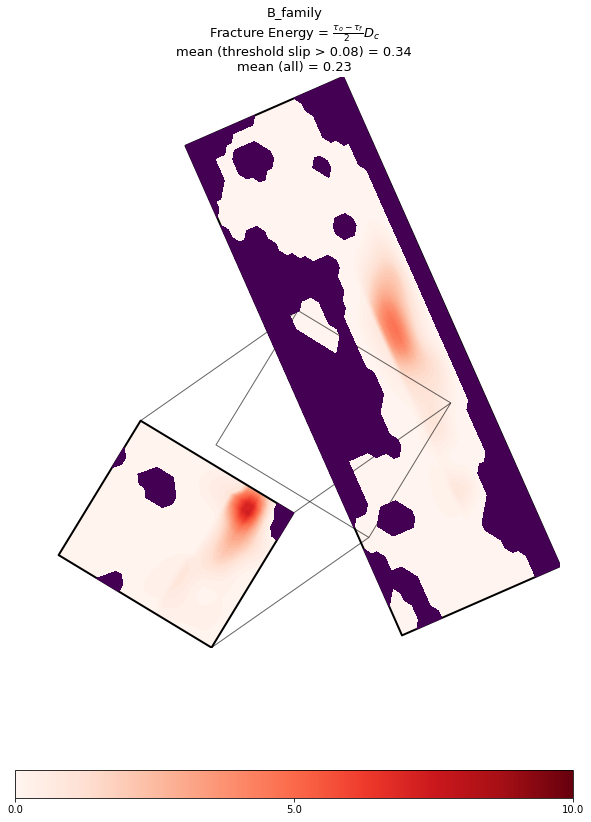

In [71]:
fig=plt.figure(figsize=[10,15])
ax=plt.gca()
v_a = .5*D_CR_a*(TAU_0_a-TAU_F_a)
v_b = .5*D_CR_b*(TAU_0_b-TAU_F_b)
femean=np.concatenate([v_a.ravel(), v_b.ravel()]).mean()
print(vmin, vmax)
print('FE min',v_a.min(), v_b.min())

thres=round(0.2*np.concatenate([slip_a.ravel(), slip_b.ravel()]).mean(),2)
v_a[slip_a<=thres]=-1
v_b[slip_b<=thres]=-1
vmin = 0
vmax = 10#max(v_a.max(), v_b.max())
femeant=np.concatenate([v_a.ravel()[slip_a.ravel()>thres], v_b.ravel()[slip_b.ravel()>thres]]).mean()
print(vmin, vmax)
print('FE min',v_a.min(), v_b.min())
txt = NOME_SIMULAZIONE+'\nFracture Energy = $\\frac{\\tau_{o} - \\tau_{f} }{2}D_{c}$\nmean (threshold slip > '+str(thres)+') = '+str(round(femeant,2))+'\nmean (all) = '+str(round(femean,2))
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap='Reds')
ax.contourf(utmx_a, utmy_a, v_a, levels=[-1,0],
                           vmin=vmin, vmax=vmax, cmap='viridis')
ax.contourf(utmx_b-10000, utmy_b-7000, v_b, levels=[-1,0],
                           vmin=vmin, vmax=vmax, cmap='viridis')

In [72]:
v=np.concatenate([v_a.ravel()[slip_a.ravel()>.5], v_b.ravel()[slip_b.ravel()>.5]])
v.mean()

0.8871512984198652

## FAMILY C

In [73]:
NOME_SIMULAZIONE='C_family'

### dynamic friction $\mu_d$ , static friction $\mu_s$

In [74]:
MU_D = 0.1  # dynamic friction
MU_S = 0.6  # static friction
MU_TR = 10.  # maximum static friction

### $D_c$, slip weaking critical distance

$D_c$ is a percentage of the total slip, the percentage depends on the depth

In [76]:
z_nncia=[-1500.,-4500,-7500,-14500,-29500,-35500,-43500,-100000]
dc_nncia=[0.3,0.3,0.1,0.1]
dc_nncia_add=[1.,0.,0.,0.]
D_CR_tres=0.02
D_CR_b=0.6*tmp_b 
D_CR_a=0.6*tmp_a 
D_CR_b2=0.*tmp_b 
D_CR_a2=0.*tmp_a 


for zdc,dc_val,dc_add in zip(z_nncia[len(dc_nncia)-1::-1],dc_nncia[::-1],dc_nncia_add[::-1]):
    #print(zdc,dc_val)
    cdc = depth_z_a >= zdc
    D_CR_a[cdc] = dc_val
    D_CR_a2[cdc] = dc_add
    cdc = depth_z_b >= zdc
    D_CR_b[cdc] = dc_val
    D_CR_b2[cdc] = dc_add
    
D_CR_a=D_CR_a*slip_a+D_CR_a2
cdc = D_CR_a <= D_CR_tres
D_CR_a[cdc]=D_CR_tres 
print(D_CR_a.min(),D_CR_a.max())

D_CR_b=D_CR_b*slip_b+D_CR_b2
cdc = D_CR_b <= D_CR_tres
D_CR_b[cdc]=D_CR_tres
print(D_CR_b.min(),D_CR_b.max())

0.02 1.257181831
0.02 1.104382072


### Density 

In [77]:
DENSITY_METHOD = 'vertical_depth_dependent'
rho_b = rho_val*tmp_b
rho_a = rho_val*tmp_a

for zrho, rho_val in zip(z_nncia[::-1], rho_nncia[::-1]):
    # print(zrho,rho_val,zrho/np.sin(dip*np.pi/180))
    criterium = depth_z_a >= zrho
    rho_a[criterium] = rho_val
    criterium = depth_z_b >= zrho
    rho_b[criterium] = rho_val


rho_a = rho_a-1000  # adding the presence of fluid
rho_b = rho_b-1000  # adding the presence of fluid

### Normal stress $\sigma_n$

In [78]:
NORMAL_STRESS_METHOD='vertical_depth_dependent'

# zv is negative but NORMAL_STRESS is positive in compression
NORMAL_STRESS_a = -rho_a*gravity*depth_z_a/1e6 # [MPa]
NORMAL_STRESS_uni_a = -rho_val*gravity*depth_z_a/1e6 # [MPa]

# zv is negative but NORMAL_STRESS is positive in compression
NORMAL_STRESS_b = -rho_b*gravity*depth_z_b/1e6 # [MPa]
NORMAL_STRESS_uni_b = -rho_val*gravity*depth_z_b/1e6 # [MPa]


sn_thre = 1  # [MPa]
NORMAL_STRESS_a[NORMAL_STRESS_a < sn_thre] = sn_thre
NORMAL_STRESS_b[NORMAL_STRESS_b < sn_thre] = sn_thre

### initial stress $\tau_{o}$, dynamic frictional stress $\tau_{f}=\mu_d\sigma_n$, yield stress $\tau_{y}$

In [79]:
slip_a_thres=slip_a.copy()
slip_b_thres=slip_b.copy()

Slip_thres=0.5
tsli = slip_a_thres <= Slip_thres
slip_a_thres[tsli]=Slip_thres
tsli = slip_b_thres <= Slip_thres
slip_b_thres[tsli]=Slip_thres

$\tau_{y}$ is set $\tau_y = \mu_{s} \sigma_{n}$   
then the condition $\tau_{y}$ >= 5 is applied

In [80]:
TAU_Y_a=NORMAL_STRESS_a*MU_S
TAU_Y_b=NORMAL_STRESS_b*MU_S

TauY_tres=5
ttauY = TAU_Y_a <= TauY_tres
TAU_Y_a[ttauY]=TauY_tres
ttauY = TAU_Y_b <= TauY_tres
TAU_Y_b[ttauY]=TauY_tres

mu_s_a = TAU_Y_a/NORMAL_STRESS_a
mu_s_b = TAU_Y_b/NORMAL_STRESS_b

mu_s_a=np.minimum(mu_s_a,MU_TR)
TAU_Y_a=mu_s_a*NORMAL_STRESS_a
mu_s_b=np.minimum(mu_s_b,MU_TR)
TAU_Y_b=mu_s_b*NORMAL_STRESS_b

$\tau_{o}$ is set $\tau_{o} = c\mu_{s} \sigma_{n}$ where $c=0.80$ for fault 155 and $c=0.85$ for fault 210

In [81]:
TAU_0_a=NORMAL_STRESS_a*MU_S*0.80
TAU_0_b=NORMAL_STRESS_b*MU_S*0.85

$\tau_{f}$ is set $\tau_{f} = \tau_{o} - c_{slip \rightarrow stress}*slip$

In [82]:
SLIP_2_STRESS_FACTOR_a=5
SLIP_2_STRESS_FACTOR_b=8

TAU_F_a=TAU_0_a-slip_a_thres*SLIP_2_STRESS_FACTOR_a
TAU_F_b=TAU_0_b-slip_b_thres*SLIP_2_STRESS_FACTOR_b

mu_d_a=TAU_F_a/NORMAL_STRESS_a
mu_d_b=TAU_F_b/NORMAL_STRESS_b

tmu = mu_d_a <= MU_D
mu_d_a[tmu]= MU_D

tmu = mu_d_b <= MU_D
mu_d_b[tmu]= MU_D

TAU_F_a=NORMAL_STRESS_a*mu_d_a
TAU_F_b=NORMAL_STRESS_b*mu_d_b

In [83]:
mu_d_a = TAU_F_a/NORMAL_STRESS_a
mu_d_b = TAU_F_b/NORMAL_STRESS_b

In [84]:
stress_a=TAU_0_a
stress_b=TAU_0_b

In [85]:
R_a=np.round((stress_a-TAU_F_a)/(TAU_Y_a-TAU_F_a),1)
R_b=np.round((stress_b-TAU_F_b)/(TAU_Y_b-TAU_F_b),1)

### rotating stress tensor

In [86]:
s_yy_a, s_zz_a, s_yz_a, s_xx_a, s_xz_a, s_xy_a, s_yy_b, s_zz_b, s_yz_b, s_xx_b, s_xz_b, s_xy_b = rotating_stress_tensor(stress_a, stress_b, rake_a_mod, rake_b_mod)

### plot C

0.025 10
FE mean 0.38236227129127326 0.7539550363020017 14.775527875979424
-175.28041579563117 175.28041579563117


Text(0.5, 0.98, 'C FAMILY')

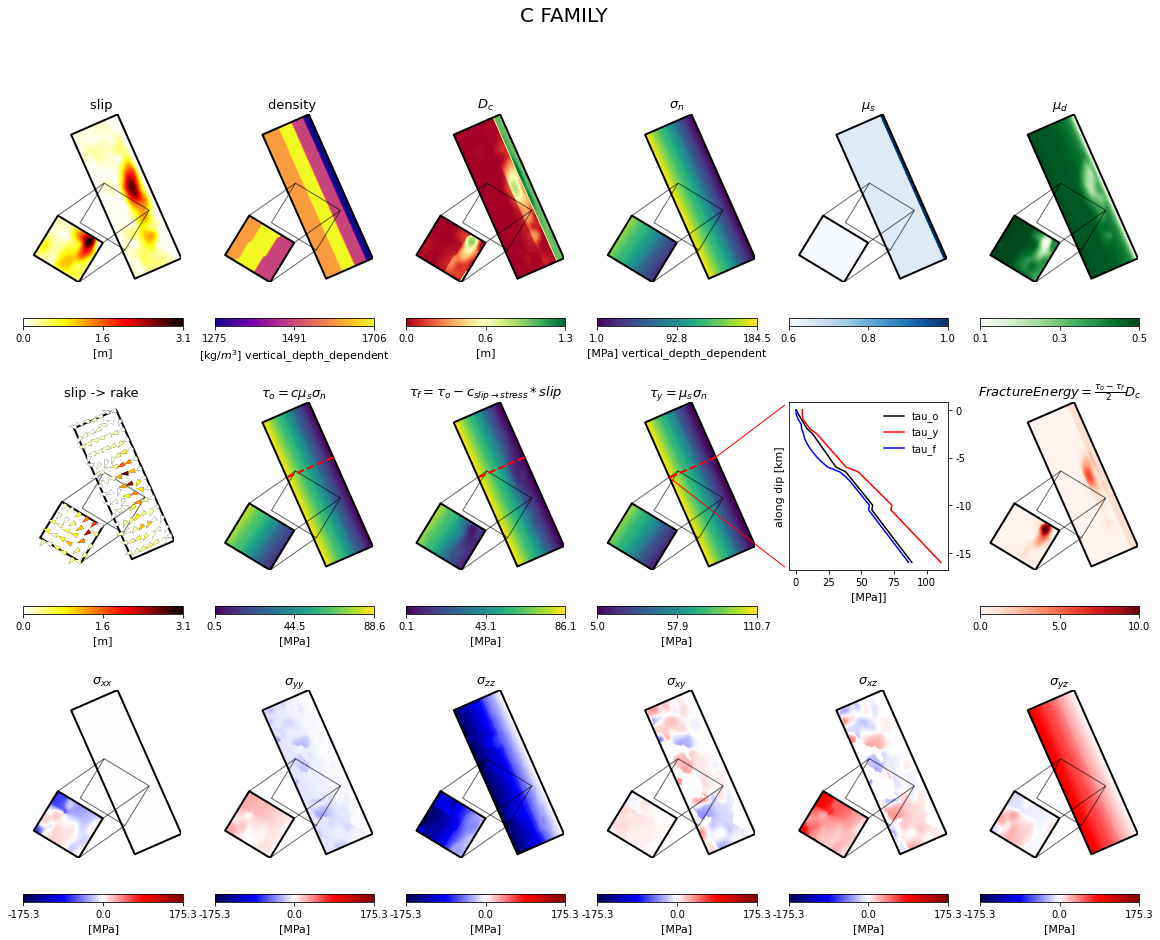

In [87]:
### C FAMILY
fig = plt.figure(figsize=(20, 15))
plt.tight_layout()

icol = 6
irow = 3
l=ind_ipo[0]

i = 1
ax = fig.add_subplot(irow, icol, i)
v_a = slip_a
v_b = slip_b
vmin = min(v_a.min(),v_b.min())
vmax = max(v_a.max(),v_b.max())
txt = 'slip [m]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap='hot_r')

i = 2
ax = fig.add_subplot(irow, icol, i)
v_a = rho_a
v_b = rho_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = 'density [kg/$m^3$] '+DENSITY_METHOD
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax,
                         txt, cmap='plasma', fmat="%.0f")

i = 3
ax = fig.add_subplot(irow, icol, i)
v_a = D_CR_a
v_b = D_CR_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$D_c$ [m]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap='RdYlGn')

i = 4
ax = fig.add_subplot(irow, icol, i)
v_a = NORMAL_STRESS_a
v_b = NORMAL_STRESS_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\sigma_n$ [MPa] '+NORMAL_STRESS_METHOD
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap='viridis')


i = 5
ax = fig.add_subplot(irow, icol, i)
v_a = mu_s_a
v_b = mu_s_b
vmin = min(v_a.min(), v_b.min())
vmax = 1# max(v_a.max(), v_b.max())
txt = '$\mu_s$'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                        cmap='Blues')

i = 6
ax = fig.add_subplot(irow, icol, i)
v_a = mu_d_a
v_b = mu_d_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\mu_d$'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap='Greens')
###########

i = 7
ax = fig.add_subplot(irow, icol, i)
v_a = slip_a
v_b = slip_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = 'slip -> rake [m]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap='hot_r',quiver=True)


i = 8
ax = fig.add_subplot(irow, icol, i)
v_a = TAU_0_a
v_b = TAU_0_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\\tau_{o} = c \\mu_s \\sigma_n$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap='viridis',profile=True)


i = 9
ax = fig.add_subplot(irow, icol, i)
v_a = TAU_F_a
v_b = TAU_F_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\\tau_{f} = \\tau_{o} - c_{slip \\rightarrow stress}*slip$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap='viridis',profile=True)


#i = 12
#ax = fig.add_subplot(irow, icol, i)
#v_a = R_a
#v_b = R_b
#vmin = min(v_a.min(), v_b.min())
#vmax = max(v_a.max(), v_b.max())
#print(vmin, vmax)
#txt = '$R = \\frac{\\tau_o - \\tau_f }{\\tau_y - \\tau_f}$'
#d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
#                         cmap='Reds')

i = 12
ax = fig.add_subplot(irow, icol, i)
v_a = .5*D_CR_a*(TAU_0_a-TAU_F_a)
v_b = .5*D_CR_b*(TAU_0_b-TAU_F_b)
vmin = min(v_a.min(), v_b.min())
vmax = 10#max(v_a.max(), v_b.max())
print(vmin, vmax)
print('FE mean',v_a.mean(), v_b.mean(),(v_a.sum()+v_b.sum())/(len(v_a)+len(v_b)))
txt = '$Fracture Energy = \\frac{\\tau_{o} - \\tau_{f} }{2}D_{c}$'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap='Reds')


v=np.concatenate([s_yy_a.ravel(), s_zz_a.ravel(), s_yz_a.ravel(), s_xx_a.ravel(), 
                s_xz_a.ravel(), s_xy_a.ravel(), s_yy_b.ravel(), s_zz_b.ravel(),
                s_yz_b.ravel(), s_xx_b.ravel(), s_xz_b.ravel(), s_xy_b.ravel()])

vmin=-max(abs(v.min()/1e6),abs(v.max()/1e6))
vmax=max(abs(v.min()/1e6),abs(v.max()/1e6))
print(vmin,vmax)
cmap='seismic'

i = 13
ax = fig.add_subplot(irow, icol, i)
v_a = s_xx_a/1e6
v_b = s_xx_b/1e6
txt = '$\sigma_{xx}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmap)


i = 14
ax = fig.add_subplot(irow, icol, i)
v_a = s_yy_a/1e6
v_b = s_yy_b/1e6
txt = '$\sigma_{yy}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmap)

i = 15
ax = fig.add_subplot(irow, icol, i)
v_a = s_zz_a/1e6
v_b = s_zz_b/1e6
txt = '$\sigma_{zz}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmap)

i = 16
ax = fig.add_subplot(irow, icol, i)
v_a = s_xy_a/1e6
v_b = s_xy_b/1e6
txt = '$\sigma_{xy}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmap)


i = 17
ax = fig.add_subplot(irow, icol, i)
v_a = s_xz_a/1e6
v_b = s_xz_b/1e6
txt = '$\sigma_{xz}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmap)

i = 18
ax = fig.add_subplot(irow, icol, i)
v_a = s_yz_a/1e6
v_b = s_yz_b/1e6
txt = '$\sigma_{yz}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmap)




i = 10
ax = fig.add_subplot(irow, icol, i)
v_a = TAU_Y_a
v_b = TAU_Y_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = ' $\\tau_y = \\mu_{s} \\sigma_{n}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap='viridis',profile=True)


i = 11
ax1 = fig.add_subplot(irow, icol, i)
ax1.plot(TAU_0_a[l,:],zv_a[l,:],label='tau_o',color='k')
ax1.plot(TAU_Y_a[l,:],zv_a[l,:],label='tau_y',color='r')
ax1.plot(TAU_F_a[l,:],zv_a[l,:],label='tau_f',color='b')
ax1.legend(frameon=False)
ax1.yaxis.tick_right()
ax1.set_yticks([0,-5000,-10000,-15000])
ax1.set_yticklabels(str(_) for _ in [0,-5,-10,-15])
ax1.set_ylabel('along dip [km]')
ax1.set_xlabel('[MPa]]')
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
clb = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=plt.cm.colors.ListedColormap(['white'])), ticks=[],
                           spacing='proportional', format='%.1f', orientation='horizontal')
clb.outline.set_visible(False)
from matplotlib.patches import ConnectionPatch
xy=(utmx_a[l,0],utmy_a[l,0])
xy1=(0,1)
con = ConnectionPatch(
    xyA=xy, coordsA=ax.transData,
    xyB=xy1, coordsB=ax1.transAxes,
    arrowstyle="-", shrinkB=5,color='r')
ax1.add_artist(con)
xy=(utmx_a[l,-1],utmy_a[l,-1])
xy1=(0,0)
con = ConnectionPatch(
    xyA=xy, coordsA=ax.transData,
    xyB=xy1, coordsB=ax1.transAxes,
    arrowstyle="-", shrinkB=5,color='r')
ax1.add_artist(con)

plt.suptitle('C FAMILY')

5.0 110.72910353044001
FE mean 0.025 0.04


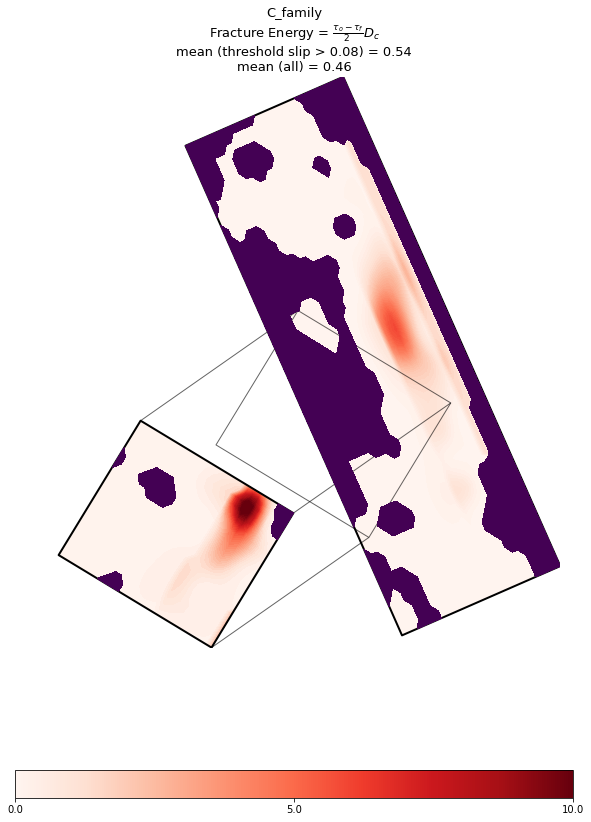

In [88]:
fig=plt.figure(figsize=[10,15])
ax=plt.gca()
v_a = .5*D_CR_a*(TAU_0_a-TAU_F_a)
v_b = .5*D_CR_b*(TAU_0_b-TAU_F_b)
femean=np.concatenate([v_a.ravel(), v_b.ravel()]).mean()
print(vmin, vmax)
print('FE mean',v_a.min(), v_b.min())


thres=round(0.2*np.concatenate([slip_a.ravel(), slip_b.ravel()]).mean(),2)
v_a[slip_a<=thres]=-1
v_b[slip_b<=thres]=-1
vmin = 0
vmax = 10#max(v_a.max(), v_b.max())
femeant=np.concatenate([v_a.ravel()[slip_a.ravel()>thres], v_b.ravel()[slip_b.ravel()>thres]]).mean()

txt = NOME_SIMULAZIONE+'\nFracture Energy = $\\frac{\\tau_{o} - \\tau_{f} }{2}D_{c}$\nmean (threshold slip > '+str(thres)+') = '+str(round(femeant,2))+'\nmean (all) = '+str(round(femean,2))
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap='Reds')
ax.contourf(utmx_a, utmy_a, v_a, levels=[-1,0],
                           vmin=vmin, vmax=vmax, cmap='viridis')
ax.contourf(utmx_b-10000, utmy_b-7000, v_b, levels=[-1,0],
                           vmin=vmin, vmax=vmax, cmap='viridis')

# CREATE 3D NETCDF FILES - FAULT EXTRUDED

In [89]:
fname210='norciax_210fault_nncia.nc'
fname210_pw='paraview_'+fname210

fname155='norciax_155fault_nncia.nc'
fname155_pw='paraview_'+fname155

In [90]:
import numpy as np
from scipy import interpolate

In [91]:
def extrapolate_nans(x, y, v):
    if np.ma.is_masked(v):
        nans = v.mask
    else:
        nans = np.isnan(v)
    notnans = np.logical_not(nans)
    v[nans] = interpolate.griddata((x[notnans], y[notnans]), v[notnans], (x[nans], y[nans]), method='nearest').ravel()
    return v

In [92]:
xcornerA = np.asarray([-17000,-17000,17000,17000])
ycornerA = np.asarray([-10911.973761,0,0,-10911.973761])

stepx = 100
stepy = 50
stepz=2
x_155 = np.linspace(xcornerA.min(),xcornerA.max(),stepx)
y_155 = np.linspace(ycornerA.min(),ycornerA.max(),stepy)
xi_155,yi_155 = np.meshgrid(x_155,y_155)

In [93]:
xp155=[]
yp155=[]
zp155=[]
for _x,_z,_s in zip(xv_a.ravel(),zv_a.ravel(),slip_a.ravel()):
    vector=rx.apply([_x,0,_z])-[17000,0,0]#by elisa 2 tentativo
    xp155.append(vector[0])
    yp155.append(vector[1])
    zp155.append(vector[2])

xp155=np.array(xp155)
yp155=np.array(yp155)
zp155=np.array(zp155)

xp155.shape=slip_a.shape
yp155.shape=slip_a.shape

x_155 = np.linspace(xp155.min(),xp155.max(),stepx)
y_155 = np.linspace(yp155.min(),yp155.max(),stepy)
z_155 = np.linspace(zp155.min(),zp155.max(),stepz)

xi_155,yi_155 = np.meshgrid(x_155,y_155)

In [107]:
def create_projection(v,stepx=100,stepy=50,stepz=2):
    v = extrapolate_nans(
        xi_155,yi_155,
        interpolate.griddata((xp155.ravel(),yp155.ravel()), v.ravel(),(xi_155,yi_155),method='linear'))
    v2 = np.tile((v.ravel()),stepz)
    v2.shape=(stepz,stepy,stepx)
    return v,v2

In [108]:
slip_p_155,slip_p_155_0=create_projection(slip_a)

In [109]:
zi_155=slip_p_155_0[0,:,:]*0+1
zi_155_1=zi_155*-11701.65923
zi_155_2=zi_155*0

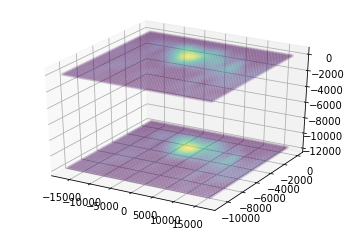

In [110]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xi_155, yi_155, zi_155_1 , c=slip_p_155.ravel(), marker='.',alpha=0.1)
ax.scatter(xi_155, yi_155, zi_155_2 , c=slip_p_155.ravel(), marker='.',alpha=0.1)

In [111]:
### output for ASAGI format

fout = Dataset('ex_'+fname155,'w',format='NETCDF4')
fout.createDimension('x',stepx)
fout.createDimension('y',stepy)
fout.createDimension('z',stepz)
fout.createVariable('x',np.float32,('x',))
fout.createVariable('y',np.float32,('y',))
fout.createVariable('z',np.float32,('z',))
fout.variables['x'][:] = x_155;
fout.variables['y'][:] = y_155;
fout.variables['z'][:] = z_155;

#initial_condition = np.dtype([('s_xx',np.dtype('f4')),
#                     ('s_yy',np.dtype('f4')),
#                     ('s_zz',np.dtype('f4')),
#                     ('s_xy',np.dtype('f4')),
#                     ('s_yz',np.dtype('f4')),
#                     ('s_xz',np.dtype('f4')),
#                     ('mu_s',np.dtype('f4')),
#                     ('mu_d',np.dtype('f4')),
#                     ('d_c',np.dtype('f4')),
#                     ('cohesion',np.dtype('f4'))])


initial_condition = np.dtype([('s_zz',np.dtype('f4')),
                              ('s_yy',np.dtype('f4')),
                              ('s_yz',np.dtype('f4')),
                              ('s_xx',np.dtype('f4')),
                              ('s_xz',np.dtype('f4')),
                              ('s_xy',np.dtype('f4')),
                              ('d_c',np.dtype('f4')),
                              ('mu_s',np.dtype('f4'))])

s_zz_p,s_zz_p_0=create_projection(s_zz_a)
s_yy_p,s_yy_p_0=create_projection(s_yy_a)
s_yz_p,s_yz_p_0=create_projection(s_yz_a)
s_xx_p,s_xx_p_0=create_projection(s_xx_a)
s_xz_p,s_xz_p_0=create_projection(s_xz_a)
s_xy_p,s_xy_p_0=create_projection(s_xy_a)
d_c_p,d_c_p_0=create_projection(D_CR_a)
mu_s_p,mu_s_p_0=create_projection(mu_s_a)




data = fout.createCompoundType(initial_condition,'initial_condition')
vv = fout.createVariable('data',data,dimensions=('z', 'y', 'x'))


for k in range(0,stepz):
    for jj in range (stepy):
        for i in range(0,stepx):
            vv[k,jj,i] = (s_zz_p_0[k,jj,i],s_yy_p_0[k,jj,i],s_yz_p_0[k,jj,i],s_xx_p_0[k,jj,i],
                          s_xz_p_0[k,jj,i],s_xy_p_0[k,jj,i],d_c_p_0[k,jj,i],mu_s_p_0[k,jj,i])
            
fout.close()

In [112]:
#for paraview
fnetcdf = Dataset('ex_'+fname155_pw, 'w', format='NETCDF3_64BIT')

fnetcdf.createDimension('x', stepx)
fnetcdf.createDimension('y', stepy)
fnetcdf.createDimension('z', stepz)

#fnetcdf.createDimension('nvar', 3)
desc = 'test'
fnetcdf.description = desc

x_nc = fnetcdf.createVariable('x', 'f4', ('x'))
y_nc = fnetcdf.createVariable('y', 'f4', ('y'))
z_nc = fnetcdf.createVariable('z', 'f4', ('z'))

s_yz_nc = fnetcdf.createVariable('s_yz', 'f4', ('z', 'y','x'))
s_yy_nc = fnetcdf.createVariable('s_yy', 'f4', ('z', 'y','x'))
s_zz_nc = fnetcdf.createVariable('s_zz', 'f4', ('z', 'y','x'))
s_xx_nc = fnetcdf.createVariable('s_xx', 'f4', ('z', 'y','x'))
s_xz_nc = fnetcdf.createVariable('s_xz', 'f4', ('z', 'y','x'))
s_xy_nc = fnetcdf.createVariable('s_xy', 'f4', ('z', 'y','x'))
dc_nc = fnetcdf.createVariable('d_c', 'f4', ('z', 'y','x'))
mu_s_nc = fnetcdf.createVariable('mu_s', 'f4', ('z', 'y','x'))
#s_xz.transpose((2,1,0))
s_zz_nc[:,:,:] = s_zz_p_0
s_yy_nc[:,:,:] = s_yy_p_0
s_yz_nc[:,:,:] = s_yz_p_0
s_xx_nc[:,:,:] = s_xx_p_0
s_xz_nc[:,:,:] = s_xz_p_0
s_xy_nc[:,:,:] = s_xy_p_0
dc_nc[:,:,:] = d_c_p_0
mu_s_nc[:,:,:] = mu_s_p_0


x_nc[:] = x_155
y_nc[:] = y_155
z_nc[:] = z_155
fnetcdf.close()




In [113]:
xcorner = np.asarray([-4514.264329707738, 
                3895.1754241867684, 
                10277.668240782505, 
                1868.2284868879979])
ycorner = np.asarray([-9430.650446469763, 
                -1797.1014780883834, 
                -9471.965636164652, 
                -17105.51460454603])

stepx = 80
stepy = 80
x_210 = np.linspace(xcorner.min(),xcorner.max(),stepx)
y_210 = np.linspace(ycorner.min(),ycorner.max(),stepy)
xi_210,yi_210 = np.meshgrid(x_210,y_210)


In [114]:
xp210=[]
yp210=[]
zp210=[]
for _x,_z,_s in zip(xv_b.ravel(),zv_b.ravel(),slip_b.ravel()):
    vector=px2.apply([_x,0,_z])+secondcorner
    xp210.append(vector[0])
    yp210.append(vector[1])
    zp210.append(vector[2])

xp210=np.array(xp210)
yp210=np.array(yp210)
zp210=np.array(zp210)

xp210.shape=slip_b.shape
yp210.shape=slip_b.shape

x_210 = np.linspace(xp210.min(),xp210.max(),stepx)
y_210 = np.linspace(yp210.min(),yp210.max(),stepy)
z_210 = np.linspace(zp210.min(),zp210.max(),stepz)
print(xp210.min(),xp210.max(),yp210.min(),yp210.max(),zp210.min(),zp210.max())
print(secondcorner)
xi_210,yi_210 = np.meshgrid(x_210,y_210)

-4514.264375273665 10277.668210151529 -17105.51457755844 -1797.1014780883834 -10113.13445825946 -1326.9507909035444
[ 3895.17542419 -1797.10147809 -1927.15539384]


In [115]:
def create_projection(v,stepx=80,stepy=80,stepz=2):
    v = extrapolate_nans(
        xi_210,yi_210,
        interpolate.griddata((xp210.ravel(),yp210.ravel()), v.ravel(),(xi_210,yi_210),method='linear'))
    v2 = np.tile((v.ravel()),stepz)
    v2.shape=(stepz,stepy,stepx) #questo ordine controlatto da casarotti (anche se y e x hanno stessa dimensione va prima la y)
    return v,v2


In [116]:
slip_p_210,slip_p_210_0=create_projection(slip_b)

In [117]:
stepz = 2 # only top and bottom

In [118]:
zi_210=slip_p_210_0[0,:,:]*0+1
zi_210_1=zi_210*-10113.134453974475
zi_210_2=zi_210*-1326.9507610865114

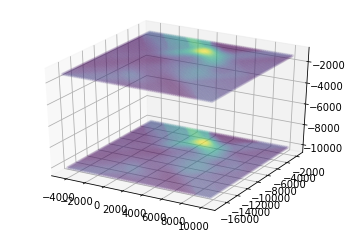

In [119]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xi_210, yi_210, zi_210_1 , c=slip_p_210.ravel(), marker='.',alpha=0.1)
ax.scatter(xi_210, yi_210, zi_210_2 , c=slip_p_210.ravel(), marker='.',alpha=0.1)

In [120]:
### output for ASAGI format
fout = Dataset('ex_'+fname210,'w',format='NETCDF4')
fout.createDimension('x',stepx)
fout.createDimension('y',stepy)
fout.createDimension('z',stepz)
fout.createVariable('x',np.float32,('x',))
fout.createVariable('y',np.float32,('y',))
fout.createVariable('z',np.float32,('z',))
fout.variables['x'][:] = x_210;
fout.variables['y'][:] = y_210;
fout.variables['z'][:] = z_210;

#initial_condition = np.dtype([('s_xx',np.dtype('f4')),
#                     ('s_yy',np.dtype('f4')),
#                     ('s_zz',np.dtype('f4')),
#                     ('s_xy',np.dtype('f4')),
#                     ('s_yz',np.dtype('f4')),
#                     ('s_xz',np.dtype('f4')),
#                     ('mu_s',np.dtype('f4')),
#                     ('mu_d',np.dtype('f4')),
#                     ('d_c',np.dtype('f4')),
#                     ('cohesion',np.dtype('f4'))])


initial_condition = np.dtype([('s_zz',np.dtype('f4')),
                              ('s_yy',np.dtype('f4')),
                              ('s_yz',np.dtype('f4')),
                              ('s_xx',np.dtype('f4')),
                              ('s_xz',np.dtype('f4')),
                              ('s_xy',np.dtype('f4')),
                              ('d_c',np.dtype('f4')),
                              ('mu_s',np.dtype('f4'))])

s_zz_p,s_zz_p_0=create_projection(s_zz_b)
s_yy_p,s_yy_p_0=create_projection(s_yy_b)
s_yz_p,s_yz_p_0=create_projection(s_yz_b)
s_xx_p,s_xx_p_0=create_projection(s_xx_b)
s_xz_p,s_xz_p_0=create_projection(s_xz_b)
s_xy_p,s_xy_p_0=create_projection(s_xy_b)
d_c_p,d_c_p_0=create_projection(D_CR_b)
mu_s_p,mu_s_p_0=create_projection(mu_s_b)




data = fout.createCompoundType(initial_condition,'initial_condition')
vv = fout.createVariable('data',data,dimensions=('z', 'y', 'x'))


for k in range(0,stepz):
    for jj in range (stepy):
        for i in range(0,stepx):
            vv[k,jj,i] = (s_zz_p_0[k,jj,i],s_yy_p_0[k,jj,i],s_yz_p_0[k,jj,i],s_xx_p_0[k,jj,i],
                          s_xz_p_0[k,jj,i],s_xy_p_0[k,jj,i],d_c_p_0[k,jj,i],mu_s_p_0[k,jj,i])
#attenti ordine degli indici: prima z poi y poi x.
            
fout.close()

In [ ]:
#for paraview
fnetcdf = Dataset('ex_'+fname210_pw, 'w', format='NETCDF3_64BIT')

fnetcdf.createDimension('x', stepx)
fnetcdf.createDimension('y', stepy)
fnetcdf.createDimension('z', stepz)

#fnetcdf.createDimension('nvar', 3)
desc = 'test'
fnetcdf.description = desc

x_nc = fnetcdf.createVariable('x', 'f4', ('x'))
y_nc = fnetcdf.createVariable('y', 'f4', ('y'))
z_nc = fnetcdf.createVariable('z', 'f4', ('z'))

s_yz_nc = fnetcdf.createVariable('s_yz', 'f4', ('z', 'y','x'))
s_yy_nc = fnetcdf.createVariable('s_yy', 'f4', ('z', 'y','x'))
s_zz_nc = fnetcdf.createVariable('s_zz', 'f4', ('z', 'y','x'))
s_xx_nc = fnetcdf.createVariable('s_xx', 'f4', ('z', 'y','x'))
s_xz_nc = fnetcdf.createVariable('s_xz', 'f4', ('z', 'y','x'))
s_xy_nc = fnetcdf.createVariable('s_xy', 'f4', ('z', 'y','x'))
dc_nc = fnetcdf.createVariable('d_c', 'f4', ('z', 'y','x'))
mu_s_nc = fnetcdf.createVariable('mu_s', 'f4', ('z', 'y','x'))
#s_xz.transpose((2,1,0))
s_zz_nc[:,:,:] = s_zz_p_0
s_yy_nc[:,:,:] = s_yy_p_0
s_yz_nc[:,:,:] = s_yz_p_0
s_xx_nc[:,:,:] = s_xx_p_0
s_xz_nc[:,:,:] = s_xz_p_0
s_xy_nc[:,:,:] = s_xy_p_0
dc_nc[:,:,:] = d_c_p_0
mu_s_nc[:,:,:] = mu_s_p_0


x_nc[:] = x_210
y_nc[:] = y_210
z_nc[:] = z_210
fnetcdf.close()

